In this notebook we explain how do we generate the volatility smile plot. 

At-the-money (ATM) options are the most liquid - we will look for the option with the strike price ($K$) closest to the forward value $F$, and treat this as the ATM option.

In an earlier notebook, we have covered how to compute implied volatility for a given option price.

Suppose $S=100$, $r=0.05$, $T=1.0$, and suppose the ATM volatility is $\sigma=0.2$. 

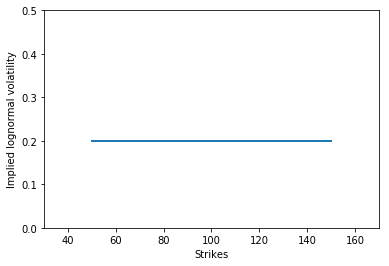

In [12]:
import pandas
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt


def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol


S = 100
r = 0.05
T = 1.0
sigma = 0.2
F = S*np.exp(r*T)
strikes = np.linspace(50, 150, 100)

summary = []
for K in strikes:
    price = BlackScholesCall(S, K, r, sigma, T)
    impliedvol = impliedCallVolatility(S, K, r, price, T)
    summary.append([K, impliedvol])

df = pandas.DataFrame(summary, columns=['strike', 'vol'])
plt.plot(df['strike'], df['vol'], linewidth=2.0)
plt.axis([30, 170, 0, 0.5])
plt.xlabel('Strikes')
plt.ylabel('Implied lognormal volatility')
plt.show()


To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

Next, we look at the SABR model. The program "sabr.py" contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.5, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.5, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.5, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [ ]:
from scipy.optimize import least_squares


def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.5, x[1], x[2]))**2

    return err


initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'].values,
                                              df['impliedvol'].values,
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
beta = 0.8
rho = res.x[1]
nu = res.x[2]
